In [ ]:
!pip install scikit_optimize
!pip install nltk
!pip install imblearn

In [ ]:
# https://www.kaggle.com/datasets/davidgauthier/glassdoor-job-reviews

# About the data 
# For the catagorical values: v - Positive, r - Mild, x - Negative, o - No opinion

import pandas as pd
import numpy as np
#from google.colab import drive
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from skopt import BayesSearchCV
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set()
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
from imblearn.datasets import make_imbalance
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
import time
from sklearn import metrics
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score
import nltk

nltk.download(['vader_lexicon'])

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Will\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [ ]:
# Load glassdoor_reviews.csv from google drive
drive.mount('/content/drive')
data = pd.read_csv("drive/MyDrive/MurphyHoltMLFinal/glassdoor_reviews.csv")

Mounted at /content/drive


In [ ]:
data = pd.read_csv("glassdoor_reviews.csv")

In [ ]:
data.shape

(838566, 18)

Exploritory data analysis and data wrangling

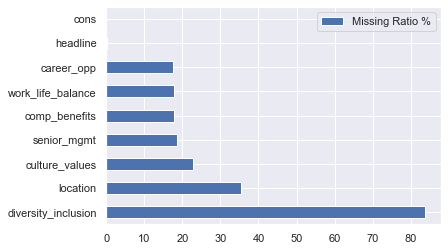

In [ ]:
# Observing the null values in our dataset.
# Since we have so much data we've opted to just drop nulls rather than imputing means
df = data
def plot_nas(df: pd.DataFrame):
    if df.isnull().sum().sum() != 0:
        na_df = (df.isnull().sum() / len(df)) * 100      
        na_df = na_df.drop(na_df[na_df == 0].index).sort_values(ascending=False)
        missing_data = pd.DataFrame({'Missing Ratio %' :na_df})
        missing_data.plot(kind = "barh")
        plt.show()
    else:
        print('No NAs found')
plot_nas(df)

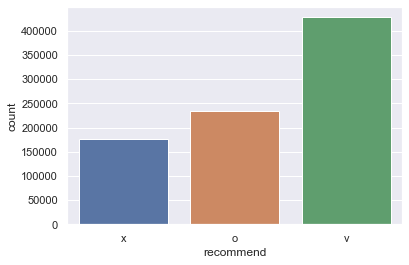

In [ ]:
sns.countplot(x = 'recommend', data = data);

In [ ]:
mostlyNumericalData = data.drop(['firm', 'date_review', 'job_title', 'current', 'location', 'diversity_inclusion'], axis = 1)
allNumericalData = pd.get_dummies(mostlyNumericalData,columns=['ceo_approv', 'outlook'])
# Get rid of the null values
numData = allNumericalData.dropna()
numData = numData.astype({"work_life_balance": int, "culture_values": int, "career_opp": int, "comp_benefits": int, "senior_mgmt": int})

# Binary encoder
def binaryTypes(row):
  if row['recommend'] == 'v':
    return 1
  else:
    return 0

# Convert types A and B to binary values with the funtion above.
numData['bin_recommend'] = numData.apply(binaryTypes, axis = 1)
numData = numData.drop(['recommend'], axis = 1)

numData.head()

,overall_rating,work_life_balance,culture_values,career_opp,comp_benefits,senior_mgmt,headline,pros,cons,ceo_approv_o,ceo_approv_r,ceo_approv_v,ceo_approv_x,outlook_o,outlook_r,outlook_v,outlook_x,bin_recommend
0,2,4,3,2,3,3,"Young colleagues, poor micro management",Very friendly and welcoming to new staff. Easy...,"Poor salaries, poor training and communication.",1,0,0,0,0,1,0,0,0
1,2,3,1,2,1,4,"Excellent staff, poor salary","Friendly, helpful and hard-working colleagues",Poor salary which doesn't improve much with pr...,1,0,0,0,0,1,0,0,0
2,1,1,1,1,1,1,"Low salary, bad micromanagement",Easy to get the job even without experience in...,"Very low salary, poor working conditions, very...",1,0,0,0,0,0,0,1,0
3,5,2,3,2,2,3,Over promised under delivered,Nice staff to work with,No career progression and salary is poor,1,0,0,0,0,1,0,0,0
4,1,2,1,2,1,1,client reporting admin,"Easy to get the job, Nice colleagues.","Abysmal pay, around minimum wage. No actual tr...",1,0,0,0,0,0,0,1,0


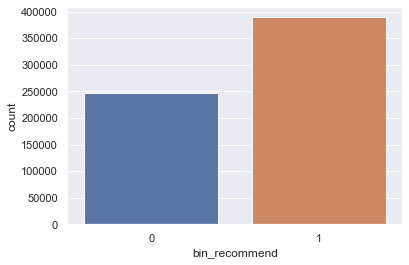

In [ ]:
# Observing out unbalanced data set.
sns.countplot(x = 'bin_recommend', data= numData);

In [ ]:
X, y = make_imbalance(
    numData[['overall_rating', 'work_life_balance', 'culture_values', 'career_opp', 'comp_benefits', 'senior_mgmt', 'ceo_approv_o', 'ceo_approv_r', 'ceo_approv_v', 'ceo_approv_x', 'outlook_o', 'outlook_r', 'outlook_v', 'outlook_x']],
    numData['bin_recommend'],
    # The two ranges below can be adjusted to include more data.
    sampling_strategy={0: 45000, 1: 45000},
    random_state = 98
) 

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 98)

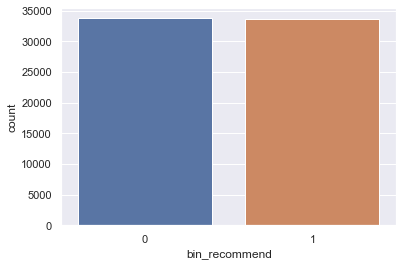

In [ ]:
# Testing to see that we have a balance data set.
yDF = pd.DataFrame(y_train)
sns.countplot(x = 'bin_recommend', data= yDF);

Model definitons for our numerical analysis using the random forest classifier.

In [ ]:
# Creating the random forest models 

rfcModel = RandomForestClassifier()

param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [1, 2, 3, 4, 5]
}


randomizedForest = RandomizedSearchCV(estimator = rfcModel,
                    param_distributions = param_grid,
                    scoring = 'accuracy',
                    n_jobs = -1,
                    cv = 10,
                    verbose = 4,
                    n_iter=50)

gridForest = GridSearchCV(estimator= rfcModel,
                       param_grid= param_grid,
                       scoring= 'accuracy',
                       n_jobs= -1,
                       cv = 10,
                       verbose = 4) 

bayesForest = BayesSearchCV(estimator = rfcModel,
                      search_spaces=param_grid,
                      scoring = 'accuracy',
                      cv=5,
                      n_jobs=-1,
                      n_iter=50,
                      verbose=0)


xgb = XGBClassifier(learning_rate=0.02, 
                    n_estimators=600, 
                    objective='binary:logistic',
                    silent=True, 
                    nthread=1)

# A parameter grid for XGBoost
xgb_params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }

le = LabelEncoder()

ytrainl = le.fit_transform(y_train)
ytestl = le.fit_transform(y_test)

xg_rand = RandomizedSearchCV(xgb, 
                               param_distributions = xgb_params, 
                               n_iter=20, 
                               scoring='roc_auc', 
                               n_jobs=-1, 
                               cv=10,
                               #cv=skf.split(X_train,y_train), 
                               verbose=20, 
                               random_state=42)

Model fitting

In [ ]:
start = time.time()
randomizedForest.fit(X_train, y_train)
end = time.time()
elapsed_time_randomizedForest = (end-start)
print(f"Elapsed time = {elapsed_time_randomizedForest:.2f}")
ypred_randomizedForest = randomizedForest.predict(X_test)

Fitting 10 folds for each of 50 candidates, totalling 500 fits
Elapsed time = 570.68


In [ ]:
start = time.time()
gridForest.fit(X_train, y_train)
end = time.time()
elapsed_time_gridForest = (end-start)
print(f"Elapsed time = {elapsed_time_gridForest:.2f}")
ypred_gridForest = gridForest.predict(X_test)

Fitting 10 folds for each of 75 candidates, totalling 750 fits
Elapsed time = 802.17


In [ ]:
start = time.time()
bayesForest.fit(X_train, y_train)
end = time.time()
elapsed_time_bayesForest = (end-start)
print(f"Elapsed time = {elapsed_time_bayesForest:.2f}")
ypred_bayesForest = bayesForest.predict(X_test)

Elapsed time = 352.17


In [ ]:
start = time.time()
xg_rand.fit(X_train, ytrainl)
end = time.time()
elapsed_time_xg_rand = (end-start)
print(f"Elapsed time = {elapsed_time_xg_rand:.2f}")
ypred_xg_rand = xg_rand.predict(X_test)

Fitting 10 folds for each of 20 candidates, totalling 200 fits
[08:20:06] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "silent" } are not used.

Elapsed time = 337.29


Results

In [ ]:
print('Randomized:\n')
print(metrics.classification_report(ypred_randomizedForest, y_test),"\n")
print(metrics.confusion_matrix(ypred_randomizedForest, y_test),"\n\n")

print('Grid:\n')
print(metrics.classification_report(ypred_gridForest, y_test),"\n")
print(metrics.confusion_matrix(ypred_gridForest, y_test),"\n\n")

print('Bayesian:\n')
print(metrics.classification_report(ypred_bayesForest, y_test),"\n")
print(metrics.confusion_matrix(ypred_bayesForest, y_test),"\n\n")

print('XGBoost:\n')
print(metrics.classification_report(ypred_xg_rand, ytestl),"\n")
print(metrics.confusion_matrix(ypred_xg_rand, ytestl),"\n\n")

Randomized:

              precision    recall  f1-score   support

           0       0.89      0.88      0.88     11296
           1       0.88      0.89      0.88     11204

    accuracy                           0.88     22500
   macro avg       0.88      0.88      0.88     22500
weighted avg       0.88      0.88      0.88     22500
 

[[9932 1364]
 [1276 9928]] 


Grid:

              precision    recall  f1-score   support

           0       0.89      0.88      0.88     11284
           1       0.88      0.89      0.88     11216

    accuracy                           0.88     22500
   macro avg       0.88      0.88      0.88     22500
weighted avg       0.88      0.88      0.88     22500
 

[[9933 1351]
 [1275 9941]] 


Bayesian:

              precision    recall  f1-score   support

           0       0.89      0.88      0.88     11298
           1       0.88      0.89      0.88     11202

    accuracy                           0.88     22500
   macro avg       0.88      0.88

Bag of Words Naive Bayesian Model

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
import re

re_tok = re.compile('[^a-zA-Z]')
def tokenize(s): 
    return re_tok.sub(' ', s).split()

count_vect = CountVectorizer(tokenizer=tokenize)

In [ ]:

mostlyTextData = data[["recommend", "headline", "pros", "cons"]]
# Get rid of the null values
textData = mostlyTextData.dropna()

# Binary encoder
def binaryTypes(row):
  if row["recommend"] == 'v':
    return 1
  else:
    return 0

textData["bin_recommend"] = textData.apply(binaryTypes, axis = 1)
textData = textData.drop(["recommend"], axis = 1)

In [ ]:
X, y = make_imbalance(
    textData[["headline", "pros", "cons"]],
    textData["bin_recommend"],
    # The two ranges below can be adjusted to include more data.
    sampling_strategy={0: 45000, 1: 45000},
    random_state = 98
) 

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 98)

In [ ]:
from sklearn.feature_extraction import text
from scipy.sparse import hstack


tf_train1 = count_vect.fit_transform(X_train['headline'])
tf_test1 = count_vect.transform(X_test['headline'])
tf_train2 = count_vect.fit_transform(X_train['pros'])
tf_test2 = count_vect.transform(X_test['pros'])
tf_train3 = count_vect.fit_transform(X_train['cons'])
tf_test3 = count_vect.transform(X_test['cons'])

tf_train = hstack((tf_train1, tf_train2, tf_train3))
tf_test = hstack((tf_test1, tf_test2, tf_test3))

tfidf_transform = text.TfidfTransformer(norm=None)
X_tfidf_train = tfidf_transform.fit_transform(tf_train)
X_tfidf_test = tfidf_transform.transform(tf_test)

print(X_tfidf_train.shape)
print(X_tfidf_test.shape)

(67500, 51361)
(22500, 51361)


Fitting the Bag of Words Model

In [ ]:
nb_model = MultinomialNB().fit(X_tfidf_train, y_train)

Results

              precision    recall  f1-score   support

           0       0.70      0.52      0.60     11208
           1       0.62      0.78      0.69     11292

    accuracy                           0.65     22500
   macro avg       0.66      0.65      0.64     22500
weighted avg       0.66      0.65      0.64     22500
 

Accuracy.........: 64.8933
Nicer confusion matrix using Seaborn heatmap:


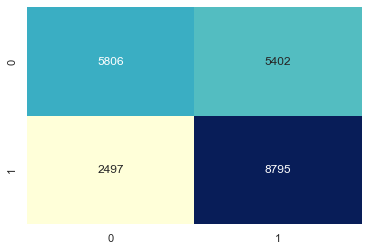

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score

nb_probs = nb_model.predict_proba(X_tfidf_test)[:,1]
nb_predictions = nb_model.predict(X_tfidf_test)

print(classification_report(y_test, nb_predictions, zero_division=1),"\n")

nb_accuracy = accuracy_score(y_test, nb_predictions)
print(f"Accuracy.........: {nb_accuracy * 100.0:.4f}")
cm = confusion_matrix(y_test, nb_predictions)

print(f"Nicer confusion matrix using Seaborn heatmap:")
sns.heatmap(cm, annot=True,fmt='d',cbar=False,cmap="YlGnBu");

Sentiment Analysis Compound

In [ ]:
from nltk.sentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

In [ ]:
def polarity(x):
  return sia.polarity_scores(x)["compound"]

In [ ]:
data_sentiment = numData
data_sentiment["headline_sentiment"] = data_sentiment['headline'].apply(polarity)
data_sentiment["pros_sentiment"] = data_sentiment['pros'].apply(polarity)
data_sentiment["cons_sentiment"] = data_sentiment['cons'].apply(polarity)
data_sentiment.head()

,overall_rating,work_life_balance,culture_values,career_opp,comp_benefits,senior_mgmt,headline,pros,cons,ceo_approv_o,...,ceo_approv_v,ceo_approv_x,outlook_o,outlook_r,outlook_v,outlook_x,bin_recommend,headline_sentiment,pros_sentiment,cons_sentiment
0,2,4,3,2,3,3,"Young colleagues, poor micro management",Very friendly and welcoming to new staff. Easy...,"Poor salaries, poor training and communication.",1,...,0,0,0,1,0,0,0,-0.4767,0.8610,-0.7351
1,2,3,1,2,1,4,"Excellent staff, poor salary","Friendly, helpful and hard-working colleagues",Poor salary which doesn't improve much with pr...,1,...,0,0,0,1,0,0,0,0.1531,0.7184,-0.8077
2,1,1,1,1,1,1,"Low salary, bad micromanagement",Easy to get the job even without experience in...,"Very low salary, poor working conditions, very...",1,...,0,0,0,0,0,1,0,-0.6808,0.4404,0.1709
3,5,2,3,2,2,3,Over promised under delivered,Nice staff to work with,No career progression and salary is poor,1,...,0,0,0,1,0,0,0,0.3612,0.4215,-0.6486
4,1,2,1,2,1,1,client reporting admin,"Easy to get the job, Nice colleagues.","Abysmal pay, around minimum wage. No actual tr...",1,...,0,0,0,0,0,1,0,0.0000,0.6908,-0.6722


In [ ]:
X, y = make_imbalance(
    data_sentiment[['overall_rating', 'work_life_balance', 'culture_values', 
             'career_opp', 'comp_benefits', 'senior_mgmt', 'ceo_approv_o', 
             'ceo_approv_r', 'ceo_approv_v', 'ceo_approv_x', 'outlook_o', 
             'outlook_r', 'outlook_v', 'outlook_x',
            "headline_sentiment", "pros_sentiment", "cons_sentiment"]],
    data_sentiment['bin_recommend'],
    # The two ranges below can be adjusted to include more data.
    sampling_strategy={0: 45000, 1: 45000},
    random_state = 98
) 

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=98)

In [ ]:
start = time.time()
randomizedForest.fit(Xtrain, ytrain)
end = time.time()
elapsed_time_random = (end-start)
print(f"Elapsed time = {elapsed_time_random:.2f}")
ypred_random = randomizedForest.predict(Xtest)

Fitting 10 folds for each of 50 candidates, totalling 500 fits
Elapsed time = 902.05


Randomized:

              precision    recall  f1-score   support

           0       0.89      0.88      0.89     11361
           1       0.88      0.89      0.89     11139

    accuracy                           0.89     22500
   macro avg       0.89      0.89      0.89     22500
weighted avg       0.89      0.89      0.89     22500
 

Nicer confusion matrix using Seaborn heatmap:


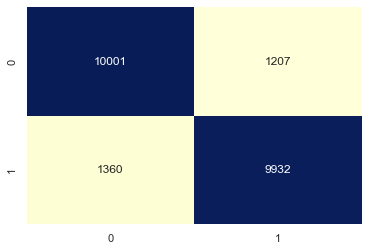

In [ ]:
print('Randomized:\n')
print(metrics.classification_report(ypred_random, ytest),"\n")

cm = confusion_matrix(y_test, ypred_random)

print(f"Nicer confusion matrix using Seaborn heatmap:")
sns.heatmap(cm, annot=True,fmt='d',cbar=False,cmap="YlGnBu");

Decision Tree with Just Sentiment Analysis

In [ ]:
X = data_sentiment[["headline_sentiment", "pros_sentiment", "cons_sentiment"]]
Y = data_sentiment["bin_recommend"]

In [ ]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, Y, random_state=0)

In [ ]:
start = time.time()
randomizedForest.fit(Xtrain, ytrain)
end = time.time()
elapsed_time_random = (end-start)
print(f"Elapsed time = {elapsed_time_random:.2f}")
ypred_random_sent = randomizedForest.predict(Xtest)

Fitting 10 folds for each of 50 candidates, totalling 500 fits
Elapsed time = 872.29


Randomized:

              precision    recall  f1-score   support

           0       0.89      0.88      0.89     11370
           1       0.88      0.89      0.89     11130

    accuracy                           0.89     22500
   macro avg       0.89      0.89      0.89     22500
weighted avg       0.89      0.89      0.89     22500
 

Nicer confusion matrix using Seaborn heatmap:


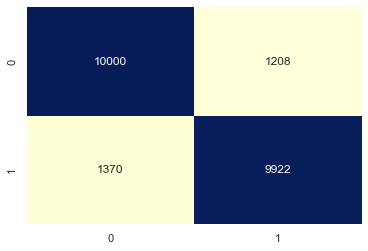

In [ ]:
print('Randomized:\n')
print(metrics.classification_report(ypred_random_sent, ytest),"\n")

cm = confusion_matrix(y_test, ypred_random_sent)

print(f"Nicer confusion matrix using Seaborn heatmap:")
sns.heatmap(cm, annot=True,fmt='d',cbar=False,cmap="YlGnBu");

I'm fixing this part now